# Modeled SLP and 750 hPa winds vs observed

In [1]:
import os
import sys
sys.path.append('../..')
import glob
import time
import xarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
from numba import float64, guvectorize
import cimf as c
from ddxddy import ddxND, ddyND
%load_ext autoreload
%autoreload 2

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.cursive'] = ['Helvetica-Oblique']
plt.rcParams['pdf.fonttype'] = 42

In [2]:
p_ref = 100000
cp = 1004
Rdry = 286.9
kappa = Rdry/cp
fc = 4.3013e-5 # coriolis parameter [s-1]

In [3]:
dsf = xarray.open_dataset("../20170905H2_AC_sub.nc")

In [4]:
# FIT AIRCRAFT EXTRAPOLATED SURFACE PRESSURE
# AND ESTIMATE TC TRACK

def fixtime(ds):
    ds['time'] = (ds.Time-ds.Time[0])
    return ds.swap_dims({'Time':'time'})

def fitpass(ds, name='PSURF.d', show=True):
    """Fit 10-degree polynomial through pressure profile of one
    flight passage through the inner core of Irma"""
    coef = ds[name].polyfit('time',10)
    fit = (xarray.polyval(ds.time,coef).polyfit_coefficients
           .rename(name))
    if show:
        p = ds[name].plot(x='Time')
        fit.plot(ax=p[0].axes, x='Time')
        p[0].axes.grid()
        plt.show()
    return fit.swap_dims({'time':'Time'})

def fit_all_passes(ds, name='PSURF.d', show=True):
    """Apply fitpass to all four flight passes and store the geographical
    location of minimum pressure from the fits."""
    passlist = [
        fixtime(ds.isel(Time=range(13500,15000))),
        fixtime(ds.isel(Time=range(17500,18750))),
        fixtime(ds.isel(Time=range(22100,23450))),
        fixtime(ds.isel(Time=range(26700,28150)))
    ]
    dsfit = xarray.Dataset()
    dsfit['eye_lat'] = xarray.full_like(ds[name], np.nan)
    dsfit['eye_lon'] = xarray.full_like(ds[name], np.nan)
    for data, suffix in zip(passlist,['_1','_2','_3','_4']):
        dsfit[name+suffix] = fitpass(data, name, show).rename(
            {'Time':'Time'+suffix})
        fitvar = dsfit[name+suffix]
        tmin = fitvar['Time'+suffix][fitvar.argmin()]
        dsfit['eye_lat'].loc[dict(Time=tmin)] = ds.LATref.loc[tmin]
        dsfit['eye_lon'].loc[dict(Time=tmin)] = ds.LONref.loc[tmin]
    dsfit['eye_lon_int'] = dsfit.eye_lon.interpolate_na('Time',fill_value='extrapolate')
    dsfit['eye_lat_int'] = dsfit.eye_lat.interpolate_na('Time',fill_value='extrapolate')
    return dsfit

dsfit = fit_all_passes(dsf, name='PSURF.d', show=False)

In [5]:
@guvectorize(
    "(float32[:], float32[:], float32[:], float32[:])",
    " (n), (n), (m) -> (m)",
    nopython=True,
)
def interp1d_gu(f, x, xi, out):
    """Interpolate field f(x) to xi in ln(x) coordinates."""
    i, imax, x0, f0 = 0, len(xi), x[0], f[0]
    while xi[i]<x0 and i < imax:
        out[i] = np.nan      
        i = i + 1 
    for x1,f1 in zip(x[1:], f[1:]):
        while xi[i] <= x1 and i < imax:
            out[i] = (f1-f0)/np.log(x1/x0)*np.log(xi[i]/x0)+f0
            i = i + 1
        x0, f0 = x1, f1
    while i < imax:
        out[i] = np.nan
        i = i + 1


def xr_interp(data, p, newp):

    interped = xarray.apply_ufunc(
        interp1d_gu,  # first the function
        data,  # now arguments in the order expected by 'interp1_np'
        p,  # as above
        newp,  # as above
        input_core_dims=[['hybrid'], ['hybrid'], ['p']],  # list with one entry per arg
        output_core_dims=[['p']],  # returned data has one dimension
        exclude_dims=set(('hybrid',)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        output_dtypes=[
            data.dtype
        ],  # one per output; could also be float or np.dtype("float64")
    ).compute()
    interped['p'] = newp

    return interped

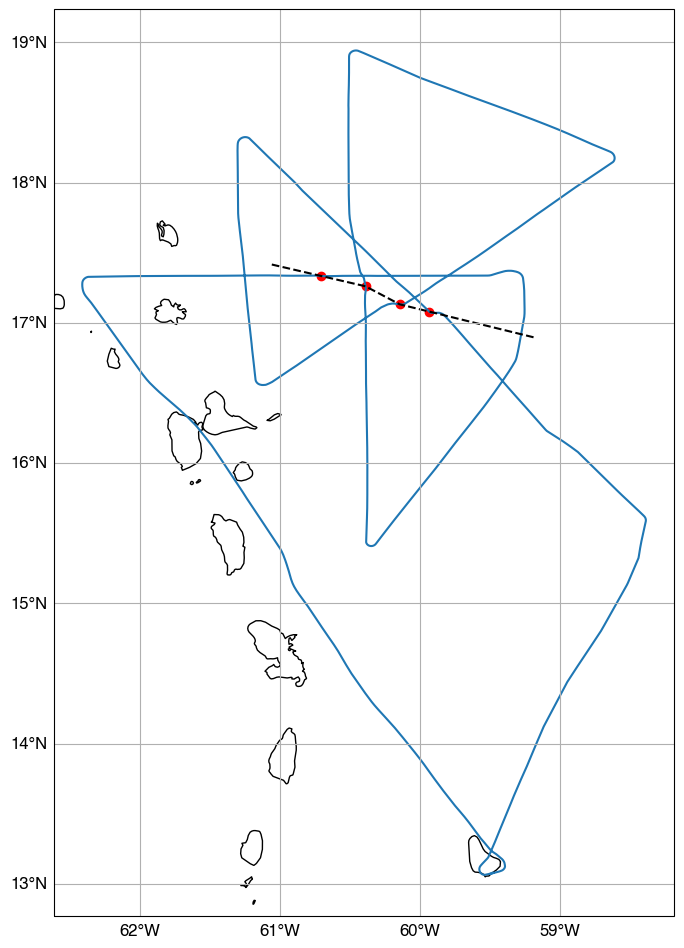

In [6]:
plt.figure(figsize=(8,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.plot(dsf.LONref, dsf.LATref, transform=ccrs.PlateCarree())
# for ii in range(0,32880,1000):
#     ax.scatter(dsf.LONref[ii],dsf.LATref[ii],color='k',alpha=ii/33000,transform=ccrs.PlateCarree())
ax.plot(dsfit.eye_lon_int, dsfit.eye_lat_int,'k--',transform=ccrs.PlateCarree())
ax.scatter(dsfit.eye_lon, dsfit.eye_lat,color='r',transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, xlim=None)
gl.right_labels=False
gl.top_labels=False
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-66,-57))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size':12}

09:14:52: distance()
09:14:52: distance()
09:14:52: distance()
09:14:52: distance()


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


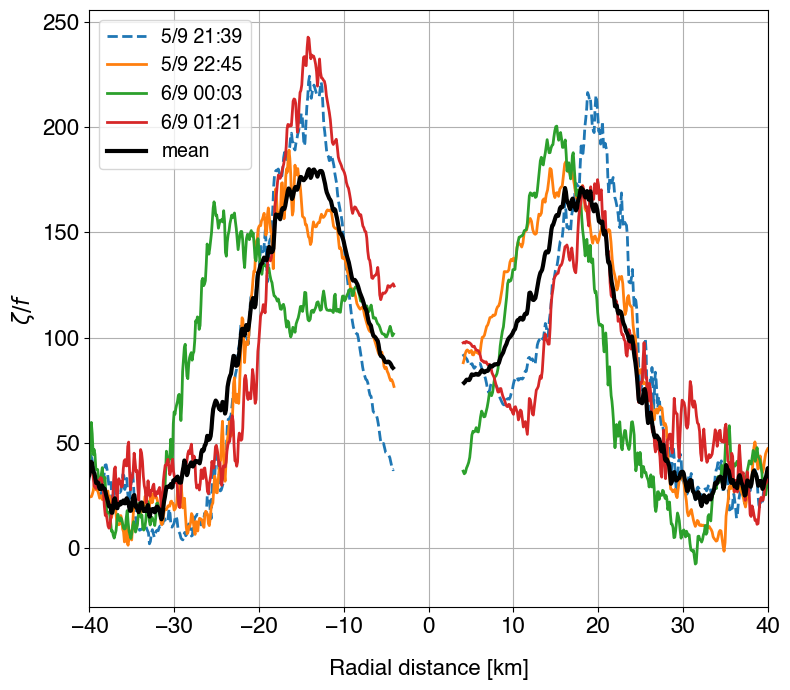

In [85]:
FSIZE=16
COLOR='tab:red'

fig = plt.figure(figsize=(8,7))
ax1 = fig.gca()
crosstimes = dsfit.eye_lat.dropna('Time').Time
xm = np.arange(-50000,50000,100) #
zetas = []
for i in range(0,4):
    suffix = '_'+str(i+1)
    times = {'Time':dsfit['Time'+suffix]}
    V = dsf['WS.d'].sel(times) # wind magnitude
    d = dsf['WD.d'].sel(times) # wind direction
    x,phi = c.distance(  # centre-aircraft distance and azimuthal coordinate
        dsfit.eye_lat_int.sel(times),
        dsfit.eye_lon_int.sel(times),
        dsf.LATref.sel(times),
        dsf.LONref.sel(times)
    )
    x = x * np.sign(times['Time']-crosstimes[i]).astype('int') # negative distance when flying toward the centre
    v = V*np.cos(phi - np.deg2rad(180-d)) # tangential wind
    vm = v.rolling({'Time'+suffix:60}, center=True).mean() # 1m rolling average
    xv = (x*vm).assign_coords(x=x)
    zeta = xv.differentiate('x')/abs(x)
    zeta[abs(x) < 4000] = np.nan
    zeta_i = xarray.DataArray(zeta.data, coords={'x':zeta.x.data}, dims='x')
    zeta_i = zeta_i.interp(x=xm)
    zetas.append(zeta_i)
    tlabel = crosstimes[i].dt.round("min").dt.strftime("%-d/%-m %H:%M").data
    ax1.plot(x/1000,zeta/fc,'--' if i==0 else '-', lw=2, label=f'{tlabel}')
plt.plot(xm/1000, np.mean(zetas, axis=0)/fc, lw=3, c='k', label='mean')
ax1.grid()
ax1.legend(fontsize=FSIZE-2)
ax1.set_xlim([-40,40])
ax1.set_xlabel('Radial distance [km]', fontsize=FSIZE, labelpad=15)
ax1.set_ylabel(r'$\zeta/f$', fontsize=FSIZE)
ax = plt.gca()
ax1.tick_params(axis='both',labelsize=FSIZE)
plt.tight_layout()
fig.savefig("fig02.pdf", format='pdf', dpi=300, bbox_inches='tight')

### Older versions (no need to run)

In [ ]:
# PLOT SLP VS AIRCRAFT RADIAL DISTANCE FROM TC CENTER
fig = plt.figure(figsize=(16,14))
ax1 = fig.gca()
ax2 = ax1.twinx()
crosstimes = dsfit.eye_lat.dropna('Time').Time
for i in range(4):
    suffix = '_'+str(i+1)
    times = {'Time':dsfit['Time'+suffix]}
    y = dsf['PSURF.d'].sel(times)
    v = dsf['WS.d'].sel(times)
    p = dsf['PS.c'].sel(times).mean('Time'+suffix).item()/100
    x,_ = c.distance(dsfit.eye_lat_int.sel(times),
                     dsfit.eye_lon_int.sel(times),
                     dsf.LATref.sel(times),
                     dsf.LONref.sel(times)
                    )
    x = x * np.sign(times['Time']-crosstimes[i]).astype('int')
    dt = crosstimes[i].dt
    ax1.plot(x/1000,y, '--' if i==0 else '-', lw=3,
             label=f'{dt.day.data}-{dt.month.data} {dt.hour.data}:{dt.minute.data:02d}')
    ax2.plot(x/1000,v,'--' if i==0 else '-', label=f'{700 if i==0 else 750} hPa')
ax1.plot(psl_harmonie.r/1000, psl_harmonie, 'k', lw=5, label='model')
ax2.plot(V700_harmonie.r/1000, V700_harmonie, 'k--', lw=5, label='700 hPa')
ax2.plot(V750_harmonie.r/1000, V750_harmonie, 'k', lw=5, label='750 hPa')
#ax1.legend(fontsize=22)
#ax2.legend(fontsize=22)
ax1.grid()
ax2.grid()
ax1.set_ylim([830,1005])
ax2.set_ylim([-5,150])
ax1.set_xlabel('Radial distance [km]', fontsize=22)
ax1.set_ylabel('Pressure [hPa]', fontsize=22)
ax2.set_ylabel('Wind speed [m/s]', fontsize=22,rotation=270, labelpad=22)
ax = plt.gca()
ax1.set_yticks(np.arange(900,1001,20))
ax2.set_yticks(np.arange(0,81,20))
ax1.tick_params(axis='both',labelsize=22)
ax2.tick_params(axis='both',labelsize=22)
plt.tight_layout()
#fig.savefig("fig/slp_v_vs_aircraft.png", dpi=300, bbox_inches='tight')

In [ ]:
# PLOT SLP VS AIRCRAFT RADIAL DISTANCE FROM TC CENTER
fig = plt.figure(figsize=(16,14))
ax1 = fig.gca()
ax2 = ax1.twinx()
crosstimes = dsfit.eye_lat.dropna('Time').Time
for i in range(4):
    suffix = '_'+str(i+1)
    times = {'Time':dsfit['Time'+suffix]}
    y = dsf['PSURF.d'].sel(times)
    v = dsf['WS.d'].sel(times)
    p = dsf['PS.c'].sel(times).mean('Time'+suffix).item()/100
    x,_ = c.distance(dsfit.eye_lat_int.sel(times),
                     dsfit.eye_lon_int.sel(times),
                     dsf.LATref.sel(times),
                     dsf.LONref.sel(times)
                    )
    x = x * np.sign(times['Time']-crosstimes[i])
    dt = crosstimes[i].dt
    ax1.plot(x/1000,y, '--' if i==0 else '-', lw=3,
             label=f'{dt.day.data}-{dt.month.data} {dt.hour.data}:{dt.minute.data:02d}')
    ax2.plot(x/1000,v,'--' if i==0 else '-', label=f'{700 if i==0 else 750} hPa')
ax1.plot(psl_harmonie.r/1000, psl_harmonie, 'k', lw=5, label='model')
ax2.plot(V700_harmonie.r/1000, V700_harmonie, 'k--', lw=5, label='700 hPa')
ax2.plot(V750_harmonie.r/1000, V750_harmonie, 'k', lw=5, label='750 hPa')
#ax1.legend(fontsize=22)
#ax2.legend(fontsize=22)
ax1.grid()
ax2.grid()
ax1.set_ylim([830,1005])
ax2.set_ylim([-5,150])
ax1.set_xlabel('Radial distance [km]', fontsize=22)
ax1.set_ylabel('Pressure [hPa]', fontsize=22)
ax2.set_ylabel('Wind speed [m/s]', fontsize=22,rotation=270, labelpad=22)
ax = plt.gca()
ax1.set_yticks(np.arange(900,1001,20))
ax2.set_yticks(np.arange(0,81,20))
ax1.tick_params(axis='both',labelsize=22)
ax2.tick_params(axis='both',labelsize=22)
plt.tight_layout()
#fig.savefig("fig/slp_v_vs_aircraft2.png", dpi=300, bbox_inches='tight')